In [1]:
%matplotlib inline

import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import librosa as lb
import librosa.display as lbd
import IPython.display as ipd
import scipy.signal as ss
import scipy.spatial as sspat
import scipy.fft as sfft
import warnings
import pickle as pkl
import time
import itertools

In [2]:
%cd ../
import CythonDTW
import TSM_Import

/home/krong/Documents/classes/SP/final/AdaptiveAccompaniment


In [3]:
hop_length = 512

In [4]:
fileId_path = "experiments/fileIds.pkl"
queryInfo_path = "experiments/queryInfo.pkl"
timeData_path = "experiments/timeData.pkl"
audioFiles_path = "experiments/audioFiles.pkl"
with open(fileId_path, 'rb') as f:
    fileIds=pkl.load(f)
with open(queryInfo_path, 'rb') as f:
    queryInfo=pkl.load(f)
with open(timeData_path, 'rb') as f:
    timeData=pkl.load(f)
with open(audioFiles_path, 'rb') as f:
    audioFiles=pkl.load(f)

In [5]:
sr = 22050

In [6]:
def getChromaFeatures(audio):
    chroma = lb.feature.chroma_stft(audio, norm=2)
    return chroma

In [7]:
def subsequencialDTW(cost_matrix):
    steps = np.array([2, 1, 1, 2, 1, 1]).reshape((3,2))
    weights = [2,1,1]
    D,wp = lb.sequence.dtw(C=cost_matrix, step_sizes_sigma=steps, weights_mul=weights, subseq=True, backtrack=True)
    return D,wp

In [8]:
def getCostMatrix(query, ref):
    return sspat.distance.cdist(query.T, ref.T, metric='cosine')

In [9]:
def inverse_time_function(wp):
    wp = wp*512
    output = np.zeros((wp[-1,0])+1)
    for pair_index in range(len(wp)-1):
        x_0 = wp[pair_index,0]
        x_1 = wp[pair_index+1,0]
        y_0 = wp[pair_index,1]
        y_1 = wp[pair_index+1,1]
        slope = (y_1-y_0)/(x_1-x_0)
        array = y_0+np.arange(x_1-x_0)*slope
        output[x_0:x_1] =array.astype(int)
    output[-1] = wp[-1,1]
    return output

In [10]:
def tf_preprocessing(local_paths):
    ls = []
    for seg in local_paths:
        new_seg = []
        for pair in seg:
            new_seg.append(np.array([pair[0],pair[1]]))
        ls.append(np.array(new_seg))
    return ls
def seg_time_function(wp):
    start_time  = time.time()
    wp = wp*hop_length
    output = np.zeros((wp[-1,1]-wp[0,1])+1)
    x_b = wp[0,1]
    for pair_index in range(len(wp)-1):
        y_0 = wp[pair_index,0]
        y_1 = wp[pair_index+1,0]
        x_0 = wp[pair_index,1]
        x_1 = wp[pair_index+1,1]
        slope = (y_1-y_0)/(x_1-x_0)
        array = y_0+np.arange(x_1-x_0)*slope
        output[x_0-x_b:x_1-x_b] = array
    output[-1] = wp[-1,0]

    return output
def group_time_function(wp,ref_audio_len):
    wp = tf_preprocessing(wp)
    start_time = time.time()

    output = np.zeros(ref_audio_len)
    

    current_start = 0
    for index, seg_path in enumerate(wp):

        pre_padd_end = seg_path[0][1] * hop_length

        output[current_start:pre_padd_end]=(np.arange(pre_padd_end-current_start)+1)+output[current_start-1]

        current_start = pre_padd_end
        tf = seg_time_function(seg_path)
        if index > 0:
            start_point = max(0,wp[index-1][-1][1]-wp[index][0][1])*hop_length
            end_point = min(len(output)-current_start,len(tf))

            tf = tf[start_point:end_point]

        if len(tf)>=2:
            output[current_start:current_start+len(tf)] = tf+tf[1]+output[current_start-1]
        elif len(tf)==1:
            output[current_start:current_start+len(tf)] = tf+output[current_start-1]
        current_start = current_start+len(tf)

    output[current_start:]=np.arange(ref_audio_len-current_start)+output[current_start-1]
    return output

In [11]:
def realTimeAccompaniment(new_input,stored_info,evaluate, sim):
    #prior = stored_info['prior']
    orchestra_chroma = stored_info['orchestra_chroma']
    '''
    audio_input = np.zeros((len(new_input)+len(prior)))
    if len(prior)>0:
        audio_input[:len(prior)]=prior
        audio_input[len(prior):]=new_input
    else:
        audio_input=new_input
    '''

    orchestra_audio = stored_info['orchestra_audio']
    input_chroma = getChromaFeatures(new_input)
    cost_matrix = getCostMatrix(input_chroma, orchestra_chroma)
    D,wp = subsequencialDTW(cost_matrix)
    wp = np.sort(wp,axis=0)
    tf, itf, audio_output = [], [], []
    if evaluate:
        tf = group_time_function([wp],len(orchestra_audio))
    if sim:
        itf = inverse_time_function(wp)
        audio_output = TSM_Import.phase_vocoder(orchestra_audio, (itf).astype(int))
    
    #stored_info['prior'].append(new_input)
    return audio_output, tf, stored_info

In [12]:
def realTimeSim(soloist, orchestra, sr = 22050):
    stored_info = dict()
    accompanyment = []
    orchestra_chroma = getChromaFeatures(orchestra)
    stored_info["orchestra_chroma"]=orchestra_chroma 
    stored_info['orchestra_audio'] = orchestra
    for solo_seg in soloist:
        accompanyment_seg = np.zeros(len(solo_seg))
        #stored_info['prior'] = []
        current_seconds = 0
        input_length_sec = .023*100
        input_length_frame = input_length_sec*sr
        num_input = int(np.ceil(len(solo_seg)/input_length_frame))
        for input_index in range(num_input):
            audio_input = solo_seg[int(input_index*input_length_frame):int((input_index+1)*input_length_frame)]
            start_time = time.time()
            audio_output, time_function_output, stored_info = realTimeAccompaniment(audio_input,stored_info,False, True)
            
            time_offset = time.time()-start_time
            print(time_offset)
            start_point = int(input_index*input_length_frame+time_offset)
            if start_point+len(audio_output)<len(accompanyment_seg):
                accompanyment_seg[start_point:start_point+len(audio_output)]=audio_output
            else:
                accompanyment_seg[start_point:]=audio_output[:len(accompanyment_seg)-start_point]
        accompanyment.append(accompanyment_seg)
    return accompanyment

In [32]:
soloist = audioFiles["p1s_perf12"]
orchestra = audioFiles["p1f_perf16"]
accompanyment = realTimeSim(soloist,orchestra)

/home/krong/Documents/classes/SP/final/AdaptiveAccompaniment/src/TSM_Import.py:128: ComplexWarning: Casting complex values to real discards the imaginary part
  spectrogram[:,index]= spec


w nom (1025, 1) hop (98,) S (1025, 98) analysis_instances (99,) S[0] (98,)
0.2548060417175293
w nom (1025, 1) hop (98,) S (1025, 98) analysis_instances (99,) S[0] (98,)
0.10673379898071289
w nom (1025, 1) hop (98,) S (1025, 98) analysis_instances (99,) S[0] (98,)
0.10602641105651855
w nom (1025, 1) hop (98,) S (1025, 98) analysis_instances (99,) S[0] (98,)
0.10366153717041016
w nom (1025, 1) hop (98,) S (1025, 98) analysis_instances (99,) S[0] (98,)
0.1100931167602539
w nom (1025, 1) hop (98,) S (1025, 98) analysis_instances (99,) S[0] (98,)
0.1100153923034668
w nom (1025, 1) hop (98,) S (1025, 98) analysis_instances (99,) S[0] (98,)
0.10537958145141602
w nom (1025, 1) hop (98,) S (1025, 98) analysis_instances (99,) S[0] (98,)
0.10469865798950195
w nom (1025, 1) hop (98,) S (1025, 98) analysis_instances (99,) S[0] (98,)
0.10859537124633789
w nom (1025, 1) hop (98,) S (1025, 98) analysis_instances (99,) S[0] (98,)
0.10270309448242188
w nom (1025, 1) hop (98,) S (1025, 98) analysis_insta

In [11]:
def get_piece():
    solo_piece = [[] for i in range(4)]
    orch_piece = [[] for i in range(4)]
    for j in timeData:
        if j[2]=="s":
            solo_piece[int(j[1])-1].append(j)
        else:
            orch_piece[int(j[1])-1].append(j)
    return orch_piece, solo_piece

In [14]:
def all_annotation_data(orch_piece, solo_piece):
    solo_seg_player_time = []
    orch_seg_player_time = []
    seg_time_key = [2,4,4,4]
    for piece_id in range(len(solo_piece)):
        piece_i = []
        for i in solo_piece[piece_id]:
            piece_i.append(timeData[i])
        segment = []
        for seg_str in queryInfo["p"+str(piece_id+1)+"s"]:

            comma = seg_str.index(",")
            start, end = seg_str[1:comma],seg_str[comma+1:-1]
            player = []
            #print(start,end)
            for pTimeData in piece_i:
                time = []
                current = start
                while current != end:
                    time.append(pTimeData[current])
                    curr_key = int(current[-1])
                    if curr_key<seg_time_key[piece_id]:
                        current=current[:-1]+str(curr_key+1)
                    else:
                        current=str(int(current[:-2])+1)+'.1'
                    #print(current)
                player.append(time)
            segment.append(player)
        solo_seg_player_time.append(segment)


    for piece_id in range(len(orch_piece)):
        piece_i = []
        for i in orch_piece[piece_id]:
            piece_i.append(timeData[i])
        segment = []
        for seg_str in queryInfo["p"+str(piece_id+1)+"s"]:

            comma = seg_str.index(",")
            start, end = seg_str[1:comma],seg_str[comma+1:-1]
            player = []
            for pTimeData in piece_i:
                time = []
                current = start
                while current != end:
                    time.append(pTimeData[current])
                    curr_key = int(current[-1])
                    if curr_key<seg_time_key[piece_id]:
                        current=current[:-1]+str(curr_key+1)
                    else:
                        current=str(int(current[:-2])+1)+'.1'
                    #print(current)
                player.append(time)
            segment.append(player)
        orch_seg_player_time.append(segment)
    return orch_seg_player_time, solo_seg_player_time

In [469]:
def findMinimalPath(est_curr_frame, est_orch_length, num_part, D):
    length_per_part = D.shape[1]//num_part
    
    part_to_choose =  min(max(est_curr_frame/D.shape[1],0),num_part-1)
    #lower_bound = max(est_curr_frame,int(length_per_part*part_to_choose))
    
    #print(D[-1,int(length_per_part*part_to_choose):int(length_per_part*(1+part_to_choose))])
    c = np.argmin(D[-1,lower_bound:int(length_per_part*(1+part_to_choose))])
    c += lower_bound
    
    if part_to_choose == num_part-1:
        if D[-1,c]>np.min(D[-1,int((part_to_choose+1)*length_per_part):]):
            c = np.argmin(D[-1,(idx+1)*length_per_part:])
            c += int((part_to_choose+1)*length_per_part)
    return c

In [459]:
np.arange(10,0,-1)

array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [518]:
def realTimeDTW(C, steps, weights, est_curr_frame):
    '''
    Find the optimal subsequence path through cost matrix C.
    
    Arguments:
    C -- cost matrix of dimension (# query frames, # reference frames)
    steps -- a numpy matrix specifying the allowable transitions.  It should be of
            dimension (L, 2), where each row specifies (row step, col step)
    weights -- a vector of size L specifying the multiplicative weights associated 
                with each of the allowable transitions
                
    Returns:
    optcost -- the optimal subsequence path score
    path -- a matrix with 2 columns specifying the optimal subsequence path.  Each row 
            specifies the (row, col) coordinate.
    '''
    D = np.full(C.shape, np.inf)
    B = np.zeros((C.shape[0],C.shape[1],2))
    est_curr_frame = min(est_curr_frame,D.shape[1])
    lower_bound = max(est_curr_frame-51,0)
    upper_bound = min(est_curr_frame+100,D.shape[1])
    ### START CODE BLOCK ###
    inf = float("inf")
    D[0,:lower_bound]=.01*np.arange(lower_bound,0,-1)
    D[0,upper_bound:]=.01*np.arange(D.shape[1]-upper_bound)
    D[0,lower_bound:upper_bound] = 0
    for i in range(1,D.shape[0]):
        for j in range(0,D.shape[1]):
            
            opt=[inf for i in range(len(steps))]
            for index, s in enumerate(steps):
                if i-s[0] >= 0 and j-s[1]>=0 and D[i-s[0],j-s[1]]!=np.inf:
                    previousCell = D[i-s[0],j-s[1]]
                    opt[index] = previousCell +C[i,j]*weights[index]
            optimal = min(opt)
            opt_index = np.argmin(np.array(opt))
            D[i][j]=optimal
            B[i][j][0]=steps[opt_index][0]
            B[i][j][1]=steps[opt_index][1]
            
    return D, B
    
    ### END CODE BLOCK ###


# In[ ]:


def realTimeBacktrace(D, B, c, steps):
    '''
    Backtraces through the cumulative cost matrix D.
    
    Arguments:
    D -- cumulative cost matrix
    B -- backtrace matrix
    steps -- a numpy matrix specifying the allowable transitions.  It should be of
            dimension (L, 2), where each row specifies (row step, col step)
    
    Returns:
    path -- a python list of (row, col) coordinates for the optimal path.
    '''

    path = []

    ### START CODE BLOCK ###

    r = B.shape[0]-1
    path = []
    while r!=0:
        path.append((r,c))
        step = B[r,c]
        r = int(np.round(r - step[0]))
        c = int(np.round(c - step[1]))
        
    path.append((r,c))
    
    ### END CODE BLOCK ###
    
    return path


In [516]:
    #
    
    assignment = []
    count = 0
    time_signature = [2,4,4,4]
    orch_piece, solo_piece  = get_piece()
    for piece_id in range(len(orch_piece)):
        
        segment_info = queryInfo['p'+str(piece_id+1)+'s']
        segment = []
        for raw_seg in segment_info:
            start, end = raw_seg[1:raw_seg.index(",")], raw_seg[raw_seg.index(",")+1:-1]
            segment.append([start,end])
        
        for segment_id in range(len(segment)):
            start, end = segment[segment_id]
            
            query_list = []
            query_index = start
            print(end)
            while query_index != end:
                #print(query_index)
                query_list.append(query_index)
                measure = int(query_index[:query_index.index('.')])
                beat = int(query_index[query_index.index('.')+1:])
                if beat == time_signature[piece_id]:
                    beat = 1
                    measure+=1
                    query_index = str(measure)+"."+str(beat)
                else:
                    beat+=1
                    query_index = str(measure)+"."+str(beat)
                query_list.append(query_index)
                
            for orch_id,solo_id in itertools.product(orch_piece[piece_id],solo_piece[piece_id]):
                
                
                assignment.append([piece_id,segment_id,orch_id,solo_id])
                for query_index in range(len(query_list)//query_length):
                    count+=1

24.1
36.1
68.1
95.1
109.1
21.3
37.4
58.3
77.1
88.3
12.3
35.1
57.3
71.1
80.1
21.3
42.3
54.1
77.3


In [507]:
count,assignment

(15303,
 [[0, 0, 'p1f_perf16', 'p1s_perf12'],
  [0, 0, 'p1f_perf16', 'p1s_perf2'],
  [0, 0, 'p1f_perf16', 'p1s_perf25'],
  [0, 0, 'p1f_perf16', 'p1s_perf3'],
  [0, 0, 'p1f_perf16', 'p1s_perf9'],
  [0, 0, 'p1f_perf2', 'p1s_perf12'],
  [0, 0, 'p1f_perf2', 'p1s_perf2'],
  [0, 0, 'p1f_perf2', 'p1s_perf25'],
  [0, 0, 'p1f_perf2', 'p1s_perf3'],
  [0, 0, 'p1f_perf2', 'p1s_perf9'],
  [0, 0, 'p1f_perf23', 'p1s_perf12'],
  [0, 0, 'p1f_perf23', 'p1s_perf2'],
  [0, 0, 'p1f_perf23', 'p1s_perf25'],
  [0, 0, 'p1f_perf23', 'p1s_perf3'],
  [0, 0, 'p1f_perf23', 'p1s_perf9'],
  [0, 0, 'p1f_perf24', 'p1s_perf12'],
  [0, 0, 'p1f_perf24', 'p1s_perf2'],
  [0, 0, 'p1f_perf24', 'p1s_perf25'],
  [0, 0, 'p1f_perf24', 'p1s_perf3'],
  [0, 0, 'p1f_perf24', 'p1s_perf9'],
  [0, 0, 'p1f_perf6', 'p1s_perf12'],
  [0, 0, 'p1f_perf6', 'p1s_perf2'],
  [0, 0, 'p1f_perf6', 'p1s_perf25'],
  [0, 0, 'p1f_perf6', 'p1s_perf3'],
  [0, 0, 'p1f_perf6', 'p1s_perf9'],
  [0, 1, 'p1f_perf16', 'p1s_perf12'],
  [0, 1, 'p1f_perf16', 'p1s_p

In [482]:
len(assignment)

423

In [529]:
count = 0
query_length = 3
error_ls = []
wp_error_ls = []
error_dict = dict()
wp_error_dict = dict()
time_signature = [2,4,4,4]
orch_piece, solo_piece  = get_piece()

for assignment_id in range(len(assignment)):
    piece_id,segment_id,orch_id,solo_id = assignment[assignment_id]
    
    if True: #for piece_id in range(len(orch_piece)):
        
        segment_info = queryInfo['p'+str(piece_id+1)+'s']
        segment = []
        for raw_seg in segment_info:
            start, end = raw_seg[1:raw_seg.index(",")], raw_seg[raw_seg.index(",")+1:-1]
            segment.append([start,end])
        
        if True: #for segment_id in range(len(segment)):
            start, end = segment[segment_id]
            
            query_list = []
            query_index = start
            print(end)
            while query_index != end:
                #print(query_index)
                query_list.append(query_index)
                measure = int(query_index[:query_index.index('.')])
                beat = int(query_index[query_index.index('.')+1:])
                if beat == time_signature[piece_id]:
                    beat = 1
                    measure+=1
                    query_index = str(measure)+"."+str(beat)
                else:
                    beat+=1
                    query_index = str(measure)+"."+str(beat)
                query_list.append(query_index)
                
            if True: # for orch_id,solo_id in itertools.product(orch_piece[piece_id],solo_piece[piece_id]):
                
                print(piece_id,segment_id,orch_id,solo_id,'\n')
                orch_time_data,solo_time_data = timeData[orch_id],timeData[solo_id]
                orch_audio,solo_audio = audioFiles[orch_id],audioFiles[solo_id][segment_id]
                first_query = query_list[0]
                orch_start_time, solo_start_time = orch_time_data[first_query], solo_time_data[first_query]
                orch_end_time = solo_time_data[query_list[-1]]
                
                ### change if we decide to assume orch start time, we havent yet, but we can
                ### online accompaniment code
                ref_audio = orch_audio
                ref_chroma = getChromaFeatures(ref_audio)
                est_curr_frame = 0
                ### end of online accompaniment code
                
                
                old_wp_start = 0
                old_est_curr_frame = 0
                for query_index in range(len(query_list)//query_length):
                    print(piece_id,segment_id,orch_id,solo_id, query_index)
                    query = [query_list[query_index+idx] for idx in range(query_length)]
                    orch_query_sec = [orch_time_data[idx] for idx in query]
                    solo_query_sec = [solo_time_data[idx] for idx in query]
                    check_nan_orch_query_sec = [math.isnan(check) for check in orch_query_sec]
                    check_nan_solo_query_sec = [math.isnan(check) for check in solo_query_sec]
                    if True in check_nan_orch_query_sec or True in check_nan_solo_query_sec:
                        continue

                    adj_solo_query_sec = np.array(solo_query_sec)-solo_start_time
                    
                    #print(solo_query_sec,orch_query_sec)
                    
                    input_audio = solo_audio[int(adj_solo_query_sec[0]*sr):int(adj_solo_query_sec[-1]*sr+1)]
                    
                    ### online accompaniment code
                    start_time = time.time()
                    input_chroma = getChromaFeatures(input_audio)
                    
                    est_orch_start_chroma_frame = max(int((orch_start_time-21)*sr/512),0)
                    est_orch_end_chroma_frame = int((orch_end_time+2)*sr/512)
                    est_orch_length =  orch_end_time - orch_start_time
                    
                                        
                    
                    cost_matrix = getCostMatrix(input_chroma, ref_chroma[:,est_orch_start_chroma_frame:est_orch_end_chroma_frame])
                    
                    steps = np.array([2, 1, 1, 2, 1, 1]).reshape((3,2))
                    weights = [1,1.5,1]
                    
                    
                    D,B = realTimeDTW(cost_matrix, steps, weights,est_curr_frame)
                    #num_part = 2
                    #c = findMinimalPath(est_curr_frame, est_orch_length, num_part, D)
                    c = np.argmin(D[-1])
                    wp = realTimeBacktrace(D, B, c, steps)
                    #D,wp = lb.sequence.dtw(C=cost_matrix, step_sizes_sigma=steps, weights_mul=weights, subseq=True, backtrack=True)
                    
                    
                    
                    wp = np.sort(wp,axis=0)
                    wp[:,1]+=est_orch_start_chroma_frame
                    
                    time_function = group_time_function([wp],len(ref_audio))
                    itf = inverse_time_function(wp)
                    
                    #audio_output = TSM_Import.phase_vocoder(ref_audio, (itf).astype(int))
                    
                    ### end of online accompaniment code
                    
                    input_time_index = (np.array(orch_query_sec) * sr).astype(int) 
                    output_time_index = [time_function[int(idx)] for idx in input_time_index]
                    output_time_sec = np.array(output_time_index)/sr
                    
                    solo_query_sec = np.array(solo_query_sec)
                    
                    output_time_sec_interval = output_time_sec[1:]-output_time_sec[:-1]
                    solo_query_sec_interval = solo_query_sec[1:]-solo_query_sec[:-1]
                    error = np.abs(np.array(output_time_sec_interval)-np.array(solo_query_sec_interval))
                    error_ls.append(error)
                    
                    
                    
                    
                    
                    
                    wp_start , wp_end = wp[0,1],wp[-1,1]
                    print(count)
                    print("curr frame",est_curr_frame,(input_time_index-orch_start_time)/512,old_est_curr_frame)
                    print("wp",wp_start-orch_start_time/512,wp_end-orch_start_time/512)
                    #print(output_time_sec_interval, solo_query_sec_interval)
                    
                    wp_error = np.abs(np.array([wp[0,1]*512 - input_time_index[0], \
                                                wp[-1,1]*512 - input_time_index[-1]])/sr)
                    wp_error_ls.append(wp_error)
                    if wp_error[0]>1 or wp_error[1]>1: 
                        
                        print("error",error)
                        print("wp error",wp_error)
                    print()
                    wp_error_dict[(piece_id,segment_id,orch_id,solo_id)] = wp_error
                    error_dict[(piece_id,segment_id,orch_id,solo_id)] = error
                    old_est_curr_frame = max(est_curr_frame,wp_start)
                    if old_wp_start != 0 and wp_start == old_wp_start and wp_start < est_curr_frame:
                        est_curr_frame+=20
                    elif old_wp_start != 0 and wp_start == old_wp_start and wp_start > 100+ est_curr_frame:
                        est_curr_frame-=50
                    elif est_curr_frame-wp_start>200 :
                        est_curr_frame+=int((est_curr_frame-wp_start)/4)
                    elif est_curr_frame-wp_start < 200:
                        est_curr_frame-=int((est_curr_frame-wp_start)/4)
                    else:
                        est_curr_frame  = max(est_curr_frame,wp_start)
                    old_wp_start = wp_start
                    
                    #print(""+1)
                    #if count == 151:
                    #    print(""+1)
                    if count % 50 == 0:
                        print()
                        wp_error_present = np.array(wp_error_ls).reshape((-1,))
                        print("result1",np.sum(np.where(np.abs(wp_error_present)<1,1,0))/len(wp_error_present))
                        print("result2",np.sum(np.where(np.abs(wp_error_present)<2,1,0))/len(wp_error_present))
                        count+=1
                        print()
                    else:
                        count+=1
#case study: 11

24.1
0 0 p1f_perf16 p1s_perf12 

0 0 p1f_perf16 p1s_perf12 0
0
curr frame 0 [626.93445687 663.99891    663.99891   ]
wp 625.9715662497637 664.9715662497637


result1 1.0
result2 1.0

0 0 p1f_perf16 p1s_perf12 1
1
curr frame 156 [663.99891    663.99891    699.57117562]
wp 524.9715662497637 550.9715662497637
error [0.         0.17513228]
wp error [3.22820862 3.45047619]

0 0 p1f_perf16 p1s_perf12 2
2
curr frame 248 [663.99891    699.57117562 699.57117562]
wp 524.9715662497637 550.9715662497637
error [0.17513228 0.        ]
wp error [3.22820862 3.45047619]

0 0 p1f_perf16 p1s_perf12 3
3
curr frame 198 [699.57117562 699.57117562 733.50086312]
wp 153.97156624976367 172.97156624976367
error [0.         0.07812547]
wp error [12.66879819 13.01546485]

0 0 p1f_perf16 p1s_perf12 4
4
curr frame 187 [699.57117562 733.50086312 733.50086312]
wp 153.97156624976367 172.97156624976367
error [0.07812547 0.        ]
wp error [12.66879819 13.01546485]

0 0 p1f_perf16 p1s_perf12 5
5
curr frame 207 [733.500

45
curr frame 107 [733.50086312 733.50086312 766.6629725 ]
wp 330.97156624976367 351.97156624976367
error [0.         0.15910809]
wp error [9.34671202 9.62911565]

0 0 p1f_perf16 p1s_perf25 6
46
curr frame 163 [733.50086312 766.6629725  766.6629725 ]
wp 330.97156624976367 351.97156624976367
error [0.15910809 0.        ]
wp error [9.34671202 9.62911565]

0 0 p1f_perf16 p1s_perf25 7
47
curr frame 113 [766.6629725  766.6629725  797.65125375]
wp 769.9715662497637 792.9715662497637

0 0 p1f_perf16 p1s_perf25 8
48
curr frame 277 [766.6629725  797.65125375 797.65125375]
wp 769.9715662497637 792.9715662497637

0 0 p1f_perf16 p1s_perf25 9
49
curr frame 227 [797.65125375 797.65125375 830.71961312]
wp 309.97156624976367 337.97156624976367
error [0.         0.19091459]
wp error [11.32390023 11.4415873 ]

0 0 p1f_perf16 p1s_perf25 10
50
curr frame 247 [797.65125375 830.71961312 830.71961312]
wp 309.97156624976367 337.97156624976367
error [0.19091459 0.        ]
wp error [11.32390023 11.4415873 ]




95
curr frame 481 [900.02430062 900.02430062 934.12781625]
wp 633.9715662497637 663.9715662497637
error [0.         0.05448224]
wp error [6.17773243 6.27301587]

0 0 p1f_perf16 p1s_perf9 16
96
curr frame 519 [900.02430062 934.12781625 934.12781625]
wp 633.9715662497637 663.9715662497637
error [0.05448224 0.        ]
wp error [6.17773243 6.27301587]

0 0 p1f_perf16 p1s_perf9 17
97
curr frame 469 [934.12781625 934.12781625 968.43836312]
wp 524.9715662497637 546.9715662497637
error [0.         0.08261527]
wp error [9.50058957 9.78643991]

0 0 p1f_perf16 p1s_perf9 18
98
curr frame 483 [934.12781625 968.43836312 968.43836312]
wp 524.9715662497637 546.9715662497637
error [0.08261527 0.        ]
wp error [9.50058957 9.78643991]

0 0 p1f_perf16 p1s_perf9 19
99
curr frame 493 [ 968.43836312  968.43836312 1000.96570687]
wp 700.9715662497637 726.9715662497637
error [0.         0.13945578]
wp error [6.21056689 6.36213152]

24.1
0 0 p1f_perf2 p1s_perf12 

0 0 p1f_perf2 p1s_perf12 0
100
curr frame 0

0 0 p1f_perf2 p1s_perf25 0
140
curr frame 0 [789.12436661 822.84702286 822.84702286]
wp 462.96421036470184 486.96421036470184
error [0.22595616 0.        ]
wp error [7.57342404 7.79918367]

0 0 p1f_perf2 p1s_perf25 1
141
curr frame 115 [822.84702286 822.84702286 856.41342911]
wp 592.9642103647018 611.9642103647018
error [0.         0.07578231]
wp error [5.33786848 5.67609977]

0 0 p1f_perf2 p1s_perf25 2
142
curr frame 234 [822.84702286 856.41342911 856.41342911]
wp 592.9642103647018 611.9642103647018
error [0.07578231 0.        ]
wp error [5.33786848 5.67609977]

0 0 p1f_perf2 p1s_perf25 3
143
curr frame 184 [856.41342911 856.41342911 886.63803849]
wp 179.9642103647018 197.9642103647018
error [0.         0.14377929]
wp error [15.70712018 15.99097506]

0 0 p1f_perf2 p1s_perf25 4
144
curr frame 183 [856.41342911 886.63803849 886.63803849]
wp 179.9642103647018 197.9642103647018
error [0.14377929 0.        ]
wp error [15.70712018 15.99097506]

0 0 p1f_perf2 p1s_perf25 5
145
curr frame 203 

KeyboardInterrupt: 

In [514]:

    D = np.full(C.shape, np.inf)
    B = np.zeros((C.shape[0],C.shape[1],2))
    est_curr_frame = min(est_curr_frame,D.shape[1])
    lower_bound = max(est_curr_frame-51,0)
    upper_bound = min(est_curr_frame+51,D.shape[1])
    ### START CODE BLOCK ###
    inf = float("inf")
    D[0,:lower_bound]=.01*np.arange(lower_bound,0,-1)
    D[0,upper_bound:]=.01*np.arange(D.shape[1]-upper_bound)
    D[0,lower_bound:upper_bound] = 0
    for i in range(1,D.shape[0]):
        for j in range(0,D.shape[1]):
            
            opt=[inf for i in range(len(steps))]
            for index, s in enumerate(steps):
                if i-s[0] >= 0 and j-s[1]>=0 and D[i-s[0],j-s[1]]!=np.inf:
                    previousCell = D[i-s[0],j-s[1]]
                    opt[index] = previousCell +C[i,j]*weights[index]
            optimal = min(opt)
            opt_index = np.argmin(np.array(opt))
            D[i][j]=optimal
            B[i][j][0]=steps[opt_index][0]
            B[i][j][1]=steps[opt_index][1]

In [499]:
max(est_curr_frame-51,0),D.shape[1]

(1381, 1194)

In [ ]:
if wp changes too much, add a catcher or something.
for instance, if wp does not increase for 10 iterations, then add 30 frames 


In [475]:
#nothing
    count = 0
    query_length = 3
    error_ls = dict()
    wp_error_ls = dict()
    time_signature = [2,4,4,4]
    orch_piece, solo_piece  = get_piece()
    for piece_id in range(len(orch_piece)):
        
        segment_info = queryInfo['p'+str(piece_id+1)+'s']
        segment = []
        for raw_seg in segment_info:
            start, end = raw_seg[1:raw_seg.index(",")], raw_seg[raw_seg.index(",")+1:-1]
            segment.append([start,end])
        
        for segment_id in range(len(segment)):
            start, end = segment[segment_id]
            
            query_list = []
            query_index = start
            print(end)
            while query_index != end:
                #print(query_index)
                query_list.append(query_index)
                measure = int(query_index[:query_index.index('.')])
                beat = int(query_index[query_index.index('.')+1:])
                if beat == time_signature[piece_id]:
                    beat = 1
                    measure+=1
                    query_index = str(measure)+"."+str(beat)
                else:
                    beat+=1
                    query_index = str(measure)+"."+str(beat)
                query_list.append(query_index)
                
            for orch_id,solo_id in itertools.product(orch_piece[piece_id],solo_piece[piece_id]):
                
                print(piece_id,segment_id,orch_id,solo_id,'\n')
                orch_time_data,solo_time_data = timeData[orch_id],timeData[solo_id]
                orch_audio,solo_audio = audioFiles[orch_id],audioFiles[solo_id][segment_id]
                first_query = query_list[0]
                orch_start_time, solo_start_time = orch_time_data[first_query], solo_time_data[first_query]
                orch_end_time = solo_time_data[query_list[-1]]
                
                ### change if we decide to assume orch start time, we havent yet, but we can
                ### online accompaniment code
                ref_audio = orch_audio
                ref_chroma = getChromaFeatures(ref_audio)
                est_curr_frame = 0
                ### end of online accompaniment code
                
                
                
                
                for query_index in range(len(query_list)-query_length):
                    print(piece_id,segment_id,orch_id,solo_id, query_index)
                    query = [query_list[query_index+idx] for idx in range(query_length)]
                    orch_query_sec = [orch_time_data[idx] for idx in query]
                    solo_query_sec = [solo_time_data[idx] for idx in query]
                    check_nan_orch_query_sec = [math.isnan(check) for check in orch_query_sec]
                    check_nan_solo_query_sec = [math.isnan(check) for check in solo_query_sec]
                    if True in check_nan_orch_query_sec or True in check_nan_solo_query_sec:
                        continue

                    adj_solo_query_sec = np.array(solo_query_sec)-solo_start_time
                    
                    #print(solo_query_sec,orch_query_sec)
                    
                    input_audio = solo_audio[int(adj_solo_query_sec[0]*sr):int(adj_solo_query_sec[-1]*sr+1)]
                    
                    ### online accompaniment code
                    input_chroma = getChromaFeatures(input_audio)
                    
                    est_orch_start_chroma_frame = max(int((orch_start_time-21)*sr/512),0)
                    est_orch_end_chroma_frame = int((orch_end_time+2)*sr/512)
                    est_orch_length =  orch_end_time - orch_start_time
                    
                                        
                    
                    cost_matrix = getCostMatrix(input_chroma, ref_chroma[:,est_orch_start_chroma_frame:est_orch_end_chroma_frame])
                    
                    steps = np.array([2, 1, 1, 2, 1, 1]).reshape((3,2))
                    weights = [1,1.5,1]
                    
                    
                    D,B = realTimeDTW(cost_matrix, steps, weights,est_curr_frame)
                    #num_part = 2
                    #c = findMinimalPath(est_curr_frame, est_orch_length, num_part, D)
                    c = np.argmin(D[-1])
                    wp = realTimeBacktrace(D, B, c, steps)
                    #D,wp = lb.sequence.dtw(C=cost_matrix, step_sizes_sigma=steps, weights_mul=weights, subseq=True, backtrack=True)
                    
                    
                    
                    wp = np.sort(wp,axis=0)
                    wp[:,1]+=est_orch_start_chroma_frame
                    
                    time_function = group_time_function([wp],len(ref_audio))
                    itf = inverse_time_function(wp)
                    
                    ### end of online accompaniment code
                    
                    input_time_index = (np.array(orch_query_sec) * sr).astype(int) 
                    output_time_index = [time_function[int(idx)] for idx in input_time_index]
                    output_time_sec = np.array(output_time_index)/sr
                    
                    solo_query_sec = np.array(solo_query_sec)
                    
                    output_time_sec_interval = output_time_sec[1:]-output_time_sec[:-1]
                    solo_query_sec_interval = solo_query_sec[1:]-solo_query_sec[:-1]
                    error = np.abs(np.array(output_time_sec_interval)-np.array(solo_query_sec_interval))
                    error_ls.append(error)
                    
                    
                    
                    
                    
                    
                    wp_start , wp_end = wp[0,1],wp[-1,1]
                    print(count)
                    print("curr frame",est_curr_frame,(input_time_index-orch_start_time)/512)
                    
                    #print(output_time_sec_interval, solo_query_sec_interval)
                    
                    if len(wp)>2:
                        wp_error = np.abs(np.array([wp[0,1]*512 - input_time_index[0], \
                                                wp[-1,1]*512 - input_time_index[-1]])/sr)
                        print(wp[0,1],wp[-1,1])
                    elif len(wp)==1:
                        wp_error = [wp[0,1]*512/sr - input_time_index[0]/sr,3.14]
                    else:
                        wp_error = [3.14,3.14]
                    wp_error_ls.append(wp_error)
                    print("error",error)
                    print("wp error",wp_error)
                    print()
                    
                    
                    est_curr_frame  = max(est_curr_frame,wp_start)
                    
                    
                    
                    #print(""+1)
                    #if count == 100:
                    #   print(""+1)
                    if count % 50 == 0:
                        print()
                        wp_error_present = np.array(wp_error_ls).reshape((-1,))
                        print("result1",np.sum(np.where(np.abs(wp_error_present)<1,1,0))/len(wp_error_present))
                        print("result2",np.sum(np.where(np.abs(wp_error_present)<2,1,0))/len(wp_error_present))
                        count+=1
                        print()
                    else:
                        count+=1
#case study: 11

24.1
0 0 p1f_perf16 p1s_perf12 

0 0 p1f_perf16 p1s_perf12 0
0
curr frame 0 [626.93445687 663.99891    663.99891   ]
626 665
error [0.05721088 0.        ]
wp error [0.02235828 0.02258503]


result1 1.0
result2 1.0

0 0 p1f_perf16 p1s_perf12 1
1
curr frame 626 [663.99891    663.99891    699.57117562]
589 611
error [0.         0.17513228]
wp error [1.74213152 2.05727891]

0 0 p1f_perf16 p1s_perf12 2
2
curr frame 626 [663.99891    699.57117562 699.57117562]
589 611
error [0.17513228 0.        ]
wp error [1.74213152 2.05727891]

0 0 p1f_perf16 p1s_perf12 3
3
curr frame 626 [699.57117562 699.57117562 733.50086312]
705 726
error [0.        0.2933938]
wp error [0.12539683 0.17482993]

0 0 p1f_perf16 p1s_perf12 4
4
curr frame 705 [699.57117562 733.50086312 733.50086312]
786 806
error [0.07812547 0.        ]
wp error [2.00621315 1.68276644]

0 0 p1f_perf16 p1s_perf12 5
5
curr frame 786 [733.50086312 733.50086312 766.6629725 ]
741 762
error [0.         0.25951625]
wp error [0.17346939 0.10893424

50
curr frame 1437 [1467.50867562 1498.96961312 1498.96961312]
1345 1363
error [0.12332577 0.        ]
wp error [2.84530612 3.15786848]


result1 0.7450980392156863
result2 0.8529411764705882

0 0 p1f_perf16 p1s_perf12 51
51
curr frame 1437 [1498.96961312 1498.96961312 1532.6473475 ]
1237 1256
error [0.         0.07626606]
wp error [6.08358277 6.42439909]

0 0 p1f_perf16 p1s_perf12 52
52
curr frame 1437 [1498.96961312 1532.6473475  1532.6473475 ]
1237 1256
error [0.07626606 0.        ]
wp error [6.08358277 6.42439909]

0 0 p1f_perf16 p1s_perf12 53
53
curr frame 1437 [1532.6473475  1532.6473475  1565.63562875]
1245 1275
error [0.         0.21711262]
wp error [6.67981859 6.74920635]

0 0 p1f_perf16 p1s_perf12 54
54
curr frame 1437 [1532.6473475  1565.63562875 1565.63562875]
1245 1275
error [0.21711262 0.        ]
wp error [6.67981859 6.74920635]

0 0 p1f_perf16 p1s_perf12 55
55
curr frame 1437 [1565.63562875 1565.63562875 1598.97937875]
1278 1297
error [0.         0.09824641]
wp error [6

100
curr frame 1432 [1366.95789437 1366.95789437 1400.93836312]
1371 1393
error [0.         0.26071051]
wp error [0.09319728 0.18498866]


result1 0.7227722772277227
result2 0.806930693069307

0 0 p1f_perf16 p1s_perf2 44
101
curr frame 1432 [1366.95789437 1400.93836312 1400.93836312]
1371 1393
error [0.26071051 0.        ]
wp error [0.09319728 0.18498866]

0 0 p1f_perf16 p1s_perf2 45
102
curr frame 1432 [1400.93836312 1400.93836312 1433.03406625]
1407 1429
error [0.         0.23173091]
wp error [0.1400907  0.09433107]

0 0 p1f_perf16 p1s_perf2 46
103
curr frame 1432 [1400.93836312 1433.03406625 1433.03406625]
1407 1429
error [0.23173091 0.        ]
wp error [0.1400907  0.09433107]

0 0 p1f_perf16 p1s_perf2 47
104
curr frame 1432 [1433.03406625 1433.03406625 1467.50867562]
1435 1452
error [0.         0.38334089]
wp error [0.04498866 0.36077098]

0 0 p1f_perf16 p1s_perf2 48
105
curr frame 1435 [1433.03406625 1467.50867562 1467.50867562]
1435 1452
error [0.38334089 0.        ]
wp error [0

150
curr frame 1237 [1235.56726937 1268.73719125 1268.73719125]
1237 1257
error [0.29475435 0.        ]
wp error [0.03260771 0.27319728]


result1 0.6556291390728477
result2 0.7119205298013245

0 0 p1f_perf16 p1s_perf25 37
151
curr frame 1237 [1268.73719125 1268.73719125 1301.1317225 ]
1264 1294
error [0.         0.06253968]
wp error [0.1106576 0.1662585]

0 0 p1f_perf16 p1s_perf25 38
152
curr frame 1264 [1268.73719125 1301.1317225  1301.1317225 ]
1264 1294
error [0.06253968 0.        ]
wp error [0.1106576 0.1662585]

0 0 p1f_perf16 p1s_perf25 39
153
curr frame 1264 [1301.1317225  1301.1317225  1334.78406625]
1305 1330
error [0.        0.1895994]
wp error [0.089161   0.11174603]

0 0 p1f_perf16 p1s_perf25 40
154
curr frame 1305 [1301.1317225  1334.78406625 1334.78406625]
1305 1330
error [0.1895994 0.       ]
wp error [0.089161   0.11174603]

0 0 p1f_perf16 p1s_perf25 41
155
curr frame 1305 [1334.78406625 1334.78406625 1366.95789437]
1023 1049
error [0.         0.17643235]
wp error [7.2

200
curr frame 1100 [1133.89539437 1133.89539437 1168.827035  ]
1136 1165
error [0.         0.12214664]
wp error [0.04820862 0.08952381]


result1 0.6442786069651741
result2 0.6990049751243781

0 0 p1f_perf16 p1s_perf3 30
201
curr frame 1136 [1133.89539437 1168.827035   1168.827035  ]
1136 1165
error [0.12214664 0.        ]
wp error [0.04820862 0.08952381]

0 0 p1f_perf16 p1s_perf3 31
202
curr frame 1136 [1168.827035   1168.827035   1204.03211312]
1169 1204
error [0.         0.00309902]
wp error [0.00335601 0.0014059 ]

0 0 p1f_perf16 p1s_perf3 32
203
curr frame 1169 [1168.827035   1204.03211312 1204.03211312]
1169 1204
error [0.00309902 0.        ]
wp error [0.00335601 0.0014059 ]

0 0 p1f_perf16 p1s_perf3 33
204
curr frame 1169 [1204.03211312 1204.03211312 1235.56726937]
1198 1221
error [0.        0.0953288]
wp error [0.14072562 0.33891156]

0 0 p1f_perf16 p1s_perf3 34
205
curr frame 1198 [1204.03211312 1235.56726937 1235.56726937]
1198 1221
error [0.0953288 0.       ]
wp error [0.14

250
curr frame 1004 [1000.96570687 1034.03211312 1034.03211312]
1004 1028
error [0.19815571 0.        ]
wp error [0.06979592 0.14072562]


result1 0.6792828685258964
result2 0.7470119521912351

0 0 p1f_perf16 p1s_perf9 23
251
curr frame 1004 [1034.03211312 1034.03211312 1066.1942225 ]
1037 1058
error [0.         0.23650794]
wp error [0.06825397 0.19092971]

0 0 p1f_perf16 p1s_perf9 24
252
curr frame 1037 [1034.03211312 1066.1942225  1066.1942225 ]
1037 1058
error [0.23650794 0.        ]
wp error [0.06825397 0.19092971]

0 0 p1f_perf16 p1s_perf9 25
253
curr frame 1037 [1066.1942225  1066.1942225  1099.23914437]
1068 1094
error [0.         0.15197279]
wp error [0.04126984 0.12231293]

0 0 p1f_perf16 p1s_perf9 26
254
curr frame 1068 [1066.1942225  1099.23914437 1099.23914437]
1068 1094
error [0.15197279 0.        ]
wp error [0.04126984 0.12231293]

0 0 p1f_perf16 p1s_perf9 27
255
curr frame 1068 [1099.23914437 1099.23914437 1133.89539437]
1099 1122
error [0.         0.24990174]
wp error [

300
curr frame 1020 [1044.24155411 1044.24155411 1076.22397599]
798 822
error [0.         0.13094482]
wp error [5.71854875 5.90390023]


result1 0.6661129568106312
result2 0.7259136212624585

0 0 p1f_perf2 p1s_perf12 16
301
curr frame 1020 [1044.24155411 1076.22397599 1076.22397599]
798 822
error [0.13094482 0.        ]
wp error [5.71854875 5.90390023]

0 0 p1f_perf2 p1s_perf12 17
302
curr frame 1020 [1076.22397599 1076.22397599 1109.58139786]
1077 1108
error [0.         0.03723356]
wp error [0.01718821 0.03755102]

0 0 p1f_perf2 p1s_perf12 18
303
curr frame 1077 [1076.22397599 1109.58139786 1109.58139786]
1081 1108
error [0.13011338 0.        ]
wp error [0.11006803 0.03755102]

0 0 p1f_perf2 p1s_perf12 19
304
curr frame 1081 [1109.58139786 1109.58139786 1140.90366349]
1108 1126
error [0.         0.25201814]
wp error [0.03755102 0.34689342]

0 0 p1f_perf2 p1s_perf12 20
305
curr frame 1108 [1109.58139786 1140.90366349 1140.90366349]
1108 1126
error [0.25201814 0.        ]
wp error [0.03

350
curr frame 923 [919.39780411 948.97592911 948.97592911]
923 946
error [0.13229025 0.        ]
wp error [0.08281179 0.06993197]


result1 0.6509971509971509
result2 0.7022792022792023

0 0 p1f_perf2 p1s_perf2 9
351
curr frame 923 [948.97592911 948.97592911 978.91342911]
952 974
error [0.        0.1706576]
wp error [0.06938776 0.11492063]

0 0 p1f_perf2 p1s_perf2 10
352
curr frame 952 [948.97592911 978.91342911 978.91342911]
952 974
error [0.1706576 0.       ]
wp error [0.06938776 0.11492063]

0 0 p1f_perf2 p1s_perf2 11
353
curr frame 952 [ 978.91342911  978.91342911 1012.03452286]
989 1009
error [0.         0.30001512]
wp error [0.23337868 0.07129252]

0 0 p1f_perf2 p1s_perf2 12
354
curr frame 989 [ 978.91342911 1012.03452286 1012.03452286]
989 1009
error [0.30001512 0.        ]
wp error [0.23337868 0.07129252]

0 0 p1f_perf2 p1s_perf2 13
355
curr frame 989 [1012.03452286 1012.03452286 1044.24155411]
1021 1044
error [0.         0.21185185]
wp error [0.20734694 0.00643991]

0 0 p1f_p

400
curr frame 463 [822.84702286 822.84702286 856.41342911]
593 612
error [0.         0.07578231]
wp error [5.33786848 5.67609977]


result1 0.6658354114713217
result2 0.7144638403990025

0 0 p1f_perf2 p1s_perf25 2
401
curr frame 593 [822.84702286 856.41342911 856.41342911]
593 612
error [0.07578231 0.        ]
wp error [5.33786848 5.67609977]

0 0 p1f_perf2 p1s_perf25 3
402
curr frame 593 [856.41342911 856.41342911 886.63803849]
519 537
error [0.         0.14377929]
wp error [7.83555556 8.11941043]

0 0 p1f_perf2 p1s_perf25 4
403
curr frame 593 [856.41342911 886.63803849 886.63803849]
519 537
error [0.14377929 0.        ]
wp error [7.83555556 8.11941043]

0 0 p1f_perf2 p1s_perf25 5
404
curr frame 593 [886.63803849 886.63803849 919.39780411]
578 600
error [0.         0.16845049]
wp error [7.16739229 7.41723356]

0 0 p1f_perf2 p1s_perf25 6
405
curr frame 593 [886.63803849 919.39780411 919.39780411]
578 600
error [0.16845049 0.        ]
wp error [7.16739229 7.41723356]

0 0 p1f_perf2 p1s

450
curr frame 1406 [1620.70639786 1620.70639786 1652.14389786]
1373 1392
error [0.         0.16829932]
wp error [5.75256236 6.04136054]


result1 0.6319290465631929
result2 0.6773835920177383

0 0 p1f_perf2 p1s_perf25 52
451
curr frame 1406 [1620.70639786 1652.14389786 1652.14389786]
1373 1392
error [0.16829932 0.        ]
wp error [5.75256236 6.04136054]

0 0 p1f_perf2 p1s_perf25 53
452
curr frame 1406 [1652.14389786 1652.14389786 1682.74546036]
1404 1427
error [0.         0.20970522]
wp error [5.76272109 5.93922902]

0 0 p1f_perf2 p1s_perf25 54
453
curr frame 1406 [1652.14389786 1682.74546036 1682.74546036]
1404 1427
error [0.20970522 0.        ]
wp error [5.76272109 5.93922902]

0 0 p1f_perf2 p1s_perf25 55
454
curr frame 1406 [1682.74546036 1682.74546036 1714.94272599]
1392 1414
error [0.        0.2599093]
wp error [6.75192744 6.98870748]

0 0 p1f_perf2 p1s_perf25 56
455
curr frame 1406 [1682.74546036 1714.94272599 1714.94272599]
1392 1414
error [0.2599093 0.       ]
wp error [6.75

500
curr frame 1433 [1497.66928849 1528.84116349 1528.84116349]
1433 1456
error [0.25401361 0.        ]
wp error [1.50244898 1.69219955]


result1 0.6407185628742516
result2 0.6856287425149701

0 0 p1f_perf2 p1s_perf3 45
501
curr frame 1433 [1528.84116349 1528.84116349 1559.41147599]
1656 1679
error [0.         0.28701436]
wp error [2.95179138 2.77600907]

0 0 p1f_perf2 p1s_perf3 46
502
curr frame 1656 [1528.84116349 1559.41147599 1559.41147599]
1656 1679
error [0.28701436 0.        ]
wp error [2.95179138 2.77600907]

0 0 p1f_perf2 p1s_perf3 47
503
curr frame 1656 [1559.41147599 1559.41147599 1591.34702286]
1558 1582
error [0.         0.16028723]
wp error [0.03360544 0.21786848]

0 0 p1f_perf2 p1s_perf3 48
504
curr frame 1656 [1559.41147599 1591.34702286 1591.34702286]
1558 1582
error [0.16028723 0.        ]
wp error [0.03360544 0.21786848]

0 0 p1f_perf2 p1s_perf3 49
505
curr frame 1656 [1591.34702286 1591.34702286 1620.70639786]
1718 1743
error [0.         0.28524565]
wp error [2.940

550
curr frame 1373 [1402.93881974 1402.93881974 1434.61069474]
1406 1432
error [0.         0.12870748]
wp error [0.07024943 0.06145125]


result1 0.6642468239564429
result2 0.7068965517241379

0 0 p1f_perf2 p1s_perf9 38
551
curr frame 1406 [1402.93881974 1434.61069474 1434.61069474]
1406 1432
error [0.12870748 0.        ]
wp error [0.07024943 0.06145125]

0 0 p1f_perf2 p1s_perf9 39
552
curr frame 1406 [1434.61069474 1434.61069474 1465.62046036]
1308 1327
error [0.         0.14219199]
wp error [2.94072562 3.21959184]

0 0 p1f_perf2 p1s_perf9 40
553
curr frame 1406 [1434.61069474 1465.62046036 1465.62046036]
1308 1327
error [0.14219199 0.        ]
wp error [2.94072562 3.21959184]

0 0 p1f_perf2 p1s_perf9 41
554
curr frame 1406 [1465.62046036 1465.62046036 1497.66928849]
1303 1322
error [0.        0.1240514]
wp error [3.77687075 4.07986395]

0 0 p1f_perf2 p1s_perf9 42
555
curr frame 1406 [1465.62046036 1497.66928849 1497.66928849]
1303 1322
error [0.1240514 0.       ]
wp error [3.7768707

600
curr frame 1024 [1017.63956243 1050.57901555 1050.57901555]
1024 1044
error [0.29077853 0.        ]
wp error [0.14712018 0.15333333]


result1 0.6605657237936772
result2 0.699667221297837

0 0 p1f_perf23 p1s_perf12 31
601
curr frame 1024 [1050.57901555 1050.57901555 1087.57706243]
1078 1098
error [0.         0.17052154]
wp error [0.63614512 0.24145125]

0 0 p1f_perf23 p1s_perf12 32
602
curr frame 1078 [1050.57901555 1087.57706243 1087.57706243]
1078 1098
error [0.17052154 0.        ]
wp error [0.63614512 0.24145125]

0 0 p1f_perf23 p1s_perf12 33
603
curr frame 1078 [1087.57706243 1087.57706243 1119.7547968 ]
1089 1118
error [0.         0.05192744]
wp error [0.03247166 0.04131519]

0 0 p1f_perf23 p1s_perf12 34
604
curr frame 1089 [1087.57706243 1119.7547968  1119.7547968 ]
1089 1118
error [0.05192744 0.        ]
wp error [0.03247166 0.04131519]

0 0 p1f_perf23 p1s_perf12 35
605
curr frame 1089 [1119.7547968  1119.7547968  1151.06339055]
1122 1150
error [0.         0.05410431]
wp err

650
curr frame 898 [922.58682805 922.58682805 952.67276555]
925 949
error [0.         0.13408919]
wp error [0.05546485 0.08585034]


result1 0.6651305683563749
result2 0.7012288786482335

0 0 p1f_perf23 p1s_perf2 24
651
curr frame 925 [922.58682805 952.67276555 952.67276555]
925 949
error [0.13408919 0.        ]
wp error [0.05546485 0.08585034]

0 0 p1f_perf23 p1s_perf2 25
652
curr frame 925 [952.67276555 952.67276555 984.4657343 ]
958 983
error [0.         0.13578231]
wp error [0.12312925 0.03460317]

0 0 p1f_perf23 p1s_perf2 26
653
curr frame 958 [952.67276555 984.4657343  984.4657343 ]
1109 1132
error [0.1660771 0.       ]
wp error [3.6293424  3.42517007]

0 0 p1f_perf23 p1s_perf2 27
654
curr frame 1109 [ 984.4657343   984.4657343  1017.63956243]
987 1008
error [0.         0.27984883]
wp error [0.05827664 0.22439909]

0 0 p1f_perf23 p1s_perf2 28
655
curr frame 1109 [ 984.4657343  1017.63956243 1017.63956243]
987 1008
error [0.27984883 0.        ]
wp error [0.05827664 0.22439909]

0 

700
curr frame 444 [792.86026555 823.84464055 823.84464055]
212 234
error [0.20007559 0.        ]
wp error [13.48811791 13.69673469]


result1 0.6604850213980028
result2 0.6968616262482168

0 0 p1f_perf23 p1s_perf25 17
701
curr frame 444 [823.84464055 823.84464055 856.53214055]
478 500
error [0.         0.17486017]
wp error [8.03106576 8.27922902]

0 0 p1f_perf23 p1s_perf25 18
702
curr frame 478 [823.84464055 856.53214055 856.53214055]
478 500
error [0.17486017 0.        ]
wp error [8.03106576 8.27922902]

0 0 p1f_perf23 p1s_perf25 19
703
curr frame 478 [856.53214055 856.53214055 889.33878118]
614 634
error [0.         0.10311413]
wp error [5.6321542  5.92952381]

0 0 p1f_perf23 p1s_perf25 20
704
curr frame 614 [856.53214055 889.33878118 889.33878118]
614 634
error [0.10311413 0.        ]
wp error [5.6321542  5.92952381]

0 0 p1f_perf23 p1s_perf25 21
705
curr frame 614 [889.33878118 889.33878118 922.58682805]
643 666
error [0.         0.13986395]
wp error [5.72054422 5.9585034 ]

0 0 p

750
curr frame 669 [695.25284368 695.25284368 726.35245305]
699 727
error [0.         0.05422525]
wp error [0.08643991 0.01446712]


result1 0.6604527296937417
result2 0.6984021304926764

0 0 p1f_perf23 p1s_perf3 10
751
curr frame 699 [695.25284368 726.35245305 726.35245305]
699 727
error [0.05422525 0.        ]
wp error [0.08643991 0.01446712]

0 0 p1f_perf23 p1s_perf3 11
752
curr frame 699 [726.35245305 726.35245305 759.27237493]
736 762
error [0.         0.10182918]
wp error [0.22344671 0.06276644]

0 0 p1f_perf23 p1s_perf3 12
753
curr frame 736 [726.35245305 759.27237493 759.27237493]
736 762
error [0.10182918 0.        ]
wp error [0.22344671 0.06276644]

0 0 p1f_perf23 p1s_perf3 13
754
curr frame 736 [759.27237493 759.27237493 792.86026555]
770 793
error [0.        0.2421164]
wp error [0.24852608 0.00267574]

0 0 p1f_perf23 p1s_perf3 14
755
curr frame 770 [759.27237493 792.86026555 792.86026555]
770 793
error [0.2421164 0.       ]
wp error [0.24852608 0.00267574]

0 0 p1f_perf23 p

800
curr frame 580 [571.74503118 603.33878118 603.33878118]
580 602
error [0.20347695 0.        ]
wp error [0.19111111 0.03165533]


result1 0.6704119850187266
result2 0.7059925093632958

0 0 p1f_perf23 p1s_perf9 3
801
curr frame 580 [603.33878118 603.33878118 634.87784368]
602 631
error [0.         0.04027211]
wp error [0.03165533 0.09061224]

0 0 p1f_perf23 p1s_perf9 4
802
curr frame 602 [603.33878118 634.87784368 634.87784368]
602 631
error [0.04027211 0.        ]
wp error [0.03165533 0.09061224]

0 0 p1f_perf23 p1s_perf9 5
803
curr frame 602 [634.87784368 634.87784368 665.7547968 ]
644 664
error [0.         0.23569161]
wp error [0.21124717 0.04131519]

0 0 p1f_perf23 p1s_perf9 6
804
curr frame 644 [634.87784368 665.7547968  665.7547968 ]
644 664
error [0.23569161 0.        ]
wp error [0.21124717 0.04131519]

0 0 p1f_perf23 p1s_perf9 7
805
curr frame 644 [665.7547968  665.7547968  695.25284368]
668 692
error [0.         0.11422525]
wp error [0.05156463 0.07609977]

0 0 p1f_perf23 p1

851
curr frame 1152 [1399.97940618 1399.97940618 1433.00284368]
952 971
error [0.         0.13200302]
wp error [10.40263039 10.72825397]

0 0 p1f_perf23 p1s_perf9 54
852
curr frame 1152 [1399.97940618 1433.00284368 1433.00284368]
952 971
error [0.13200302 0.        ]
wp error [10.40263039 10.72825397]

0 0 p1f_perf23 p1s_perf9 55
853
curr frame 1152 [1433.00284368 1433.00284368 1462.97745305]
1434 1459
error [0.         0.09981859]
wp error [0.02258503 0.09292517]

0 0 p1f_perf23 p1s_perf9 56
854
curr frame 1434 [1433.00284368 1462.97745305 1462.97745305]
1440 1459
error [0.23913832 0.        ]
wp error [0.16190476 0.09292517]

0 0 p1f_perf24 p1s_perf12 

0 0 p1f_perf24 p1s_perf12 0
855
curr frame 0 [827.44294126 864.04059751 864.04059751]
53 75
error [0.14952381 0.        ]
wp error [17.98340136 18.32235828]

0 0 p1f_perf24 p1s_perf12 1
856
curr frame 53 [864.04059751 864.04059751 899.81598814]
661 685
error [0.         0.17041572]
wp error [4.71546485 4.98888889]

0 0 p1f_perf24 p1s_

901
curr frame 1438 [1601.72614439 1633.91950376 1633.91950376]
1386 1408
error [0.13653817 0.        ]
wp error [5.01002268 5.24671202]

0 0 p1f_perf24 p1s_perf12 47
902
curr frame 1438 [1633.91950376 1633.91950376 1667.81012876]
1386 1407
error [0.         0.13095994]
wp error [5.75755102 6.05687075]

0 0 p1f_perf24 p1s_perf12 48
903
curr frame 1438 [1633.91950376 1667.81012876 1667.81012876]
1386 1407
error [0.13095994 0.        ]
wp error [5.75755102 6.05687075]

0 0 p1f_perf24 p1s_perf12 49
904
curr frame 1438 [1667.81012876 1667.81012876 1699.86091001]
1396 1417
error [0.         0.10962963]
wp error [6.31229025 6.56888889]

0 0 p1f_perf24 p1s_perf12 50
905
curr frame 1438 [1667.81012876 1699.86091001 1699.86091001]
1396 1417
error [0.10962963 0.        ]
wp error [6.31229025 6.56888889]

0 0 p1f_perf24 p1s_perf12 51
906
curr frame 1438 [1699.86091001 1699.86091001 1733.58161314]
1438 1456
error [0.         0.07526833]
wp error [6.08126984 6.44630385]

0 0 p1f_perf24 p1s_perf12 5

951
curr frame 1501 [1501.77497251 1501.77497251 1535.81208189]
1529 1546
error [0.         0.14464097]
wp error [0.63129252 0.23569161]

0 0 p1f_perf24 p1s_perf2 40
952
curr frame 1529 [1501.77497251 1535.81208189 1535.81208189]
1529 1546
error [0.14464097 0.        ]
wp error [0.63129252 0.23569161]

0 0 p1f_perf24 p1s_perf2 41
953
curr frame 1529 [1535.81208189 1535.81208189 1568.27301939]
1535 1555
error [0.         0.25446712]
wp error [0.01972789 0.30907029]

0 0 p1f_perf24 p1s_perf2 42
954
curr frame 1535 [1535.81208189 1568.27301939 1568.27301939]
1535 1555
error [0.25446712 0.        ]
wp error [0.01972789 0.30907029]

0 0 p1f_perf24 p1s_perf2 43
955
curr frame 1535 [1568.27301939 1568.27301939 1601.72614439]
1577 1595
error [0.         0.34134543]
wp error [0.20176871 0.15705215]

0 0 p1f_perf24 p1s_perf2 44
956
curr frame 1577 [1568.27301939 1601.72614439 1601.72614439]
1577 1595
error [0.34134543 0.        ]
wp error [0.20176871 0.15705215]

0 0 p1f_perf24 p1s_perf2 45
957


1001
curr frame 1370 [1369.08747251 1402.86286314 1402.86286314]
1370 1393
error [0.24439909 0.        ]
wp error [0.02031746 0.22988662]

0 0 p1f_perf24 p1s_perf25 33
1002
curr frame 1370 [1402.86286314 1402.86286314 1436.25544126]
1401 1422
error [0.         0.26040816]
wp error [0.04412698 0.33188209]

0 0 p1f_perf24 p1s_perf25 34
1003
curr frame 1401 [1402.86286314 1436.25544126 1436.25544126]
1401 1422
error [0.26040816 0.        ]
wp error [0.04412698 0.33188209]

0 0 p1f_perf24 p1s_perf25 35
1004
curr frame 1401 [1436.25544126 1436.25544126 1469.30426939]
1288 1308
error [0.         0.17245654]
wp error [3.44335601 3.74634921]

0 0 p1f_perf24 p1s_perf25 36
1005
curr frame 1401 [1436.25544126 1469.30426939 1469.30426939]
1288 1308
error [0.17245654 0.        ]
wp error [3.44335601 3.74634921]

0 0 p1f_perf24 p1s_perf25 37
1006
curr frame 1401 [1469.30426939 1469.30426939 1501.77497251]
1274 1298
error [0.         0.25192744]
wp error [4.53582766 4.73251701]

0 0 p1f_perf24 p1s_pe

1051
curr frame 1540 [1265.26716001 1265.26716001 1299.32575376]
1268 1297
error [0.         0.10409675]
wp error [0.06258503 0.05487528]

0 0 p1f_perf24 p1s_perf3 26
1052
curr frame 1540 [1265.26716001 1299.32575376 1299.32575376]
1268 1297
error [0.10409675 0.        ]
wp error [0.06258503 0.05487528]

0 0 p1f_perf24 p1s_perf3 27
1053
curr frame 1540 [1299.32575376 1299.32575376 1334.83356626]
1300 1324
error [0.         0.25369614]
wp error [0.01478458 0.2524263 ]

0 0 p1f_perf24 p1s_perf3 28
1054
curr frame 1540 [1299.32575376 1334.83356626 1334.83356626]
1300 1324
error [0.25369614 0.        ]
wp error [0.01478458 0.2524263 ]

0 0 p1f_perf24 p1s_perf3 29
1055
curr frame 1540 [1334.83356626 1334.83356626 1369.08747251]
1336 1360
error [0.         0.22250945]
wp error [0.02621315 0.21188209]

0 0 p1f_perf24 p1s_perf3 30
1056
curr frame 1540 [1334.83356626 1369.08747251 1369.08747251]
1336 1360
error [0.22250945 0.        ]
wp error [0.02621315 0.21188209]

0 0 p1f_perf24 p1s_perf3 3

1101
curr frame 1140 [1134.59137876 1168.73395689 1168.73395689]
1140 1165
error [0.19212396 0.        ]
wp error [0.12471655 0.0875737 ]

0 0 p1f_perf24 p1s_perf9 19
1102
curr frame 1140 [1168.73395689 1168.73395689 1201.76716001]
1169 1193
error [0.         0.19736961]
wp error [0.00530612 0.20444444]

0 0 p1f_perf24 p1s_perf9 20
1103
curr frame 1169 [1168.73395689 1201.76716001 1201.76716001]
1169 1193
error [0.19736961 0.        ]
wp error [0.00530612 0.20444444]

0 0 p1f_perf24 p1s_perf9 21
1104
curr frame 1169 [1201.76716001 1201.76716001 1233.48200376]
1204 1230
error [0.         0.12033258]
wp error [0.05097506 0.08172336]

0 0 p1f_perf24 p1s_perf9 22
1105
curr frame 1204 [1201.76716001 1233.48200376 1233.48200376]
1204 1230
error [0.12033258 0.        ]
wp error [0.05097506 0.08172336]

0 0 p1f_perf24 p1s_perf9 23
1106
curr frame 1204 [1233.48200376 1233.48200376 1265.26716001]
1237 1258
error [0.        0.2277551]
wp error [0.08081633 0.16961451]

0 0 p1f_perf24 p1s_perf9 24


1151
curr frame 932 [723.07690836 723.07690836 759.95386149]
1031 1051
error [0.         0.07449735]
wp error [7.14938776 6.75750567]

0 0 p1f_perf6 p1s_perf12 12
1152
curr frame 1031 [723.07690836 759.95386149 759.95386149]
1031 1051
error [0.07449735 0.        ]
wp error [7.14938776 6.75750567]

0 0 p1f_perf6 p1s_perf12 13
1153
curr frame 1031 [759.95386149 759.95386149 792.87964274]
810 834
error [0.         0.18950869]
wp error [1.1614966  0.95424036]

0 0 p1f_perf6 p1s_perf12 14
1154
curr frame 1031 [759.95386149 792.87964274 792.87964274]
810 834
error [0.18950869 0.        ]
wp error [1.1614966  0.95424036]

0 0 p1f_perf6 p1s_perf12 15
1155
curr frame 1031 [792.87964274 792.87964274 824.08862711]
800 819
error [0.         0.26905518]
wp error [0.1647619  0.11873016]

0 0 p1f_perf6 p1s_perf12 16
1156
curr frame 1031 [792.87964274 824.08862711 824.08862711]
800 819
error [0.26905518 0.        ]
wp error [0.1647619  0.11873016]

0 0 p1f_perf6 p1s_perf12 17
1157
curr frame 1031 [824

1201
curr frame 682 [602.87183024 633.06323649 633.06323649]
683 699
error [0.06146636 0.        ]
wp error [1.86       1.53047619]

0 0 p1f_perf6 p1s_perf2 5
1202
curr frame 683 [633.06323649 633.06323649 663.50659586]
632 662
error [0.         0.03529856]
wp error [0.02526077 0.03555556]

0 0 p1f_perf6 p1s_perf2 6
1203
curr frame 683 [633.06323649 663.50659586 663.50659586]
632 662
error [0.03529856 0.        ]
wp error [0.02526077 0.03555556]

0 0 p1f_perf6 p1s_perf2 7
1204
curr frame 683 [663.50659586 663.50659586 692.64917399]
665 688
error [0.         0.12217687]
wp error [0.03410431 0.10852608]

0 0 p1f_perf6 p1s_perf2 8
1205
curr frame 683 [663.50659586 692.64917399 692.64917399]
665 688
error [0.12217687 0.        ]
wp error [0.03410431 0.10852608]

0 0 p1f_perf6 p1s_perf2 9
1206
curr frame 683 [692.64917399 692.64917399 723.07690836]
695 718
error [0.         0.15882086]
wp error [0.05401361 0.11845805]

0 0 p1f_perf6 p1s_perf2 10
1207
curr frame 695 [692.64917399 723.0769083

1251
curr frame 1478 [1402.39917399 1432.15698649 1432.15698649]
1478 1501
error [0.00161754 0.        ]
wp error [1.75487528 1.59795918]

0 0 p1f_perf6 p1s_perf2 55
1252
curr frame 1478 [1432.15698649 1432.15698649 1462.98901774]
1434 1459
error [0.         0.13504157]
wp error [0.04222222 0.09319728]

0 0 p1f_perf6 p1s_perf2 56
1253
curr frame 1478 [1432.15698649 1462.98901774 1462.98901774]
1434 1459
error [0.13504157 0.        ]
wp error [0.04222222 0.09319728]

0 0 p1f_perf6 p1s_perf25 

0 0 p1f_perf6 p1s_perf25 0
1254
curr frame 0 [543.59839274 571.26831461 571.26831461]
238 262
error [0.36650038 0.        ]
wp error [7.09655329 7.18176871]

0 0 p1f_perf6 p1s_perf25 1
1255
curr frame 238 [571.26831461 571.26831461 602.87183024]
313 332
error [0.         0.12136054]
wp error [5.99755102 6.29020408]

0 0 p1f_perf6 p1s_perf25 2
1256
curr frame 313 [571.26831461 602.87183024 602.87183024]
313 332
error [0.12136054 0.        ]
wp error [5.99755102 6.29020408]

0 0 p1f_perf6 p1s_perf25

1301
curr frame 1247 [1310.05933024 1310.05933024 1341.43433024]
1250 1274
error [0.         0.17853364]
wp error [1.39514739 1.56639456]

0 0 p1f_perf6 p1s_perf25 48
1302
curr frame 1250 [1310.05933024 1341.43433024 1341.43433024]
1250 1274
error [0.17853364 0.        ]
wp error [1.39514739 1.56639456]

0 0 p1f_perf6 p1s_perf25 49
1303
curr frame 1250 [1341.43433024 1341.43433024 1369.83862711]
1344 1369
error [0.        0.0671353]
wp error [0.05900227 0.02004535]

0 0 p1f_perf6 p1s_perf25 50
1304
curr frame 1344 [1341.43433024 1369.83862711 1369.83862711]
1344 1369
error [0.0671353 0.       ]
wp error [0.05900227 0.02004535]

0 0 p1f_perf6 p1s_perf25 51
1305
curr frame 1344 [1369.83862711 1369.83862711 1402.39917399]
1372 1391
error [0.         0.29895692]
wp error [0.04961451 0.26526077]

0 0 p1f_perf6 p1s_perf25 52
1306
curr frame 1372 [1369.83862711 1402.39917399 1402.39917399]
1372 1391
error [0.29895692 0.        ]
wp error [0.04961451 0.26526077]

0 0 p1f_perf6 p1s_perf25 53
13

1351
curr frame 1185 [1181.69409586 1212.90503336 1212.90503336]
1185 1213
error [0.07262283 0.        ]
wp error [0.07619048 0.00163265]

0 0 p1f_perf6 p1s_perf3 41
1352
curr frame 1185 [1212.90503336 1212.90503336 1245.62573649]
1242 1271
error [0.         0.21606954]
wp error [0.67501134 0.58861678]

0 0 p1f_perf6 p1s_perf3 42
1353
curr frame 1242 [1212.90503336 1245.62573649 1245.62573649]
1272 1298
error [0.3008768 0.       ]
wp error [1.37160998 1.21555556]

0 0 p1f_perf6 p1s_perf3 43
1354
curr frame 1272 [1245.62573649 1245.62573649 1279.40112711]
1328 1349
error [0.         0.19356009]
wp error [1.9121542 1.6155102]

0 0 p1f_perf6 p1s_perf3 44
1355
curr frame 1328 [1245.62573649 1279.40112711 1279.40112711]
1328 1349
error [0.19356009 0.        ]
wp error [1.9121542 1.6155102]

0 0 p1f_perf6 p1s_perf3 45
1356
curr frame 1328 [1279.40112711 1279.40112711 1310.05933024]
1288 1309
error [0.        0.2026455]
wp error [0.19909297 0.02517007]

0 0 p1f_perf6 p1s_perf3 46
1357
curr fr

1401
curr frame 1111 [1088.14526774 1088.14526774 1119.17261149]
1090 1117
error [0.         0.07138322]
wp error [0.04249433 0.05102041]

0 0 p1f_perf6 p1s_perf9 34
1402
curr frame 1111 [1088.14526774 1119.17261149 1119.17261149]
1090 1117
error [0.07138322 0.        ]
wp error [0.04249433 0.05102041]

0 0 p1f_perf6 p1s_perf9 35
1403
curr frame 1111 [1119.17261149 1119.17261149 1152.64722086]
1122 1142
error [0.         0.31055178]
wp error [0.06507937 0.24780045]

0 0 p1f_perf6 p1s_perf9 36
1404
curr frame 1122 [1119.17261149 1152.64722086 1152.64722086]
1122 1142
error [0.31055178 0.        ]
wp error [0.06507937 0.24780045]

0 0 p1f_perf6 p1s_perf9 37
1405
curr frame 1122 [1152.64722086 1152.64722086 1181.69409586]
1147 1181
error [0.        0.1800907]
wp error [0.13170068 0.01668934]

0 0 p1f_perf6 p1s_perf9 38
1406
curr frame 1147 [1152.64722086 1181.69409586 1181.69409586]
1147 1181
error [0.1800907 0.       ]
wp error [0.13170068 0.01668934]

0 0 p1f_perf6 p1s_perf9 39
1407
cur

ValueError: could not broadcast input array from shape (2010) into shape (1194)

In [ ]:
D.shape

In [307]:
(663-525)*512/sr

3.2043537414965986

In [309]:
part_to_choose

0.015093274505311607

In [310]:
orch_start_time

14.558080120999998

In [311]:
est_curr_time/est_orch_length
wp[1,1]*512/sr

21.89641723356009

1.0 0.5091100210231254
0.6355991590749824 0.6916608269096005


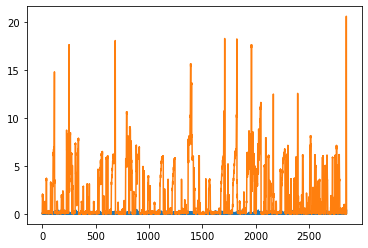

In [476]:
#eval
error_ls = np.array(error_ls).reshape((-1,))
print(np.sum(np.where(error_ls<.5,1,0))/len(error_ls),np.sum(np.where(error_ls<.01,1,0))/len(error_ls))
plt.plot(np.array(error_ls).reshape((-1,)))
wp_error_ls = np.array(wp_error_ls).reshape((-1,))
print(np.sum(np.where(np.abs(wp_error_ls)<1,1,0))/len(wp_error_ls),np.sum(np.where(np.abs(wp_error_ls)<2,1,0))/len(wp_error_ls))
plt.plot(np.array(wp_error_ls).reshape((-1,)))

In [313]:
steps = np.array([2, 1, 1, 2, 1, 1]).reshape((3,2))
weights = [1,1,1]
D,wp1 = lb.sequence.dtw(C=cost_matrix, step_sizes_sigma=steps, weights_mul=weights, subseq=True, backtrack=True)
wp1 = np.sort(wp1,axis=0)
wp1[:,1]+=est_orch_start_chroma_frame

In [448]:
# input time index should match wp
input_time_index/512, (input_time_index[0]-wp[0,1]*512)/sr, (input_time_index[-1]-wp[-1,1]*512)/sr

(array([664.02734375, 664.02734375, 699.59960938]),
 -6.245532879818594,
 -6.232244897959184)

In [449]:
wp,wp1

(array([[  0, 933],
        [  2, 934],
        [  4, 935],
        [  6, 936],
        [  8, 937],
        [  9, 939],
        [ 10, 941],
        [ 11, 942],
        [ 13, 943],
        [ 15, 944],
        [ 17, 945],
        [ 18, 947],
        [ 19, 949],
        [ 21, 950],
        [ 23, 951],
        [ 24, 953],
        [ 25, 955],
        [ 26, 957],
        [ 27, 959],
        [ 28, 960],
        [ 30, 961],
        [ 32, 962],
        [ 34, 963],
        [ 36, 964],
        [ 38, 965],
        [ 40, 966],
        [ 41, 967],
        [ 43, 968]]),
 array([[  0, 589],
        [  2, 590],
        [  4, 591],
        [  5, 592],
        [  7, 593],
        [  9, 594],
        [ 11, 595],
        [ 13, 596],
        [ 15, 597],
        [ 17, 598],
        [ 19, 599],
        [ 21, 600],
        [ 23, 601],
        [ 25, 602],
        [ 27, 603],
        [ 29, 604],
        [ 31, 605],
        [ 33, 606],
        [ 35, 607],
        [ 37, 608],
        [ 39, 609],
        [ 41, 610]

In [316]:
output_time_sec, solo_query_sec

(array([15.41873016, 16.24471655]), array([6.34347695, 7.34459562]))

In [317]:
# if output has similar interval as input,then we are not streching correctly
output_time_sec - time_function[int(orch_start_time*sr)]/sr, solo_query_sec-solo_start_time, input_time_index/sr-orch_start_time

(array([0.86063492, 1.68662132]),
 array([0.99931973, 2.0004384 ]),
 array([0.86060469, 1.68659108]))

In [318]:
conclusion: matched to the wrong thing. 

SyntaxError: invalid syntax (<ipython-input-318-28174e8b546c>, line 1)

In [319]:
approach:
requirement: provide approximate location for segments  within 1 (or variable) seconds 
solution: modify the cost matrix, add penality when far away from estimated location. 
    keep track of how long we pass through, and use that to modify cost matrix
    oh, maybe we need custom matrix for early stopping, or 0 weight transition. former is better


SyntaxError: invalid syntax (<ipython-input-319-0ec19d4d5add>, line 1)

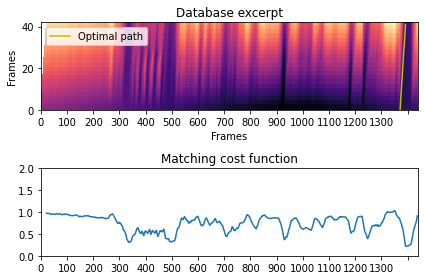

In [524]:
>>> plt.subplot(2, 1, 1)
>>> lb.display.specshow(D, x_axis='frames', y_axis='frames')
>>> plt.title('Database excerpt')
>>> plt.plot(wp[:, 1]-est_orch_start_chroma_frame, wp[:, 0], label='Optimal path', color='y')
>>> plt.xticks([i for i in range(0,D.shape[1],100)],[i for i in range(est_orch_start_chroma_frame//100*100,\
                                                                     est_orch_end_chroma_frame//100*100,100)])
>>> plt.legend()
>>> plt.subplot(2, 1, 2)
>>> plt.plot(D[-1, :] / wp.shape[0])
>>> 
>>> plt.xlim([0, D.shape[1]])
>>> plt.ylim([0, 2])
>>> plt.title('Matching cost function')
>>> plt.xticks([i for i in range(0,D.shape[1],100)],[i for i in range(est_orch_start_chroma_frame//100*100,\
                                                                     est_orch_end_chroma_frame//100*100,100)])
>>> plt.tight_layout()
>>> plt.show()

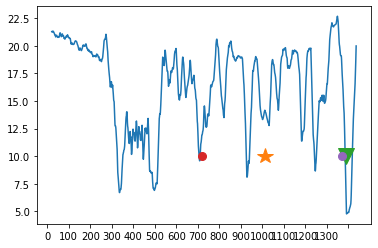

In [526]:
plt.plot(D[-1]),est_orch_start_chroma_frame, input_time_index
plt.xticks([i for i in range(0,D.shape[1],100)],[i for i in range(est_orch_start_chroma_frame//100*100,\
                                                                     est_orch_end_chroma_frame//100*100,100)])
# goal
plt.plot(input_time_index[-1]/512-est_orch_start_chroma_frame,10,marker="*", markersize=16)
# prediction
plt.plot(wp[-1,1]-est_orch_start_chroma_frame,10,marker="v", markersize=16)
plt.plot(D.shape[1]//2,10,marker=".", markersize=16)
input_time_index/512
plt.plot((est_curr_frame),10,marker=".", markersize=16)

In [527]:
est_curr_frame

1371

In [436]:
wp,c,est_curr_frame, D.shape[1]

(array([[  0, 828]]), 828, 828, 1475)

In [439]:
c

828

In [440]:
D[-1][828]

0.0

In [256]:
def evalBeatRealTime(sr=22050):
    error_ls = []
    
    print("start preparation")
    orch_piece, solo_piece  = get_piece()
    orch_seg_player_time, solo_seg_player_time= all_annotation_data(orch_piece, solo_piece)
    diff_seg_player = []
    
    input_num_beat = 4
    
    piece_id = 0
    count=0
    correct = 0
    tolerance = .5
    print("complete preparation")
    
    for piece_id in range(len(orch_seg_player_time)):
        print("new piece",piece_id)
        for seg_id in range(len(orch_seg_player_time[piece_id])):
            print("new seg",seg_id)
            diff_o_s_player = []
            for o_player_id in range(len(orch_seg_player_time[piece_id][seg_id])):
                
                
                orch_piece_id = orch_piece[piece_id][o_player_id]
                orch_audio = audioFiles[orch_piece_id]
                orch_time = solo_seg_player_time[piece_id][seg_id][o_player_id]
                
                
                for s_player_id in range(len(solo_seg_player_time[piece_id][seg_id])):
                    
                    
                    solo_piece_id = solo_piece[piece_id][o_player_id]
                    
                    
                    solo_audio  = audioFiles[solo_piece_id][seg_id]
                    
                    stored_info = dict()
                    orchestra_chroma = getChromaFeatures(orch_audio)
                    stored_info["orchestra_chroma"]=orchestra_chroma 
                    stored_info['orchestra_audio'] = orch_audio
                    stored_info['prior'] = []
                    stored_info["last end"] = 0
                    solo_time = solo_seg_player_time[piece_id][seg_id][s_player_id]
                    ground_truth_baseline_sec = solo_time[0]
                    
                    print("seg",seg_id,"player combo",o_player_id,s_player_id,len(solo_time)-input_num_beat-1)
                    
                    for i in range(len(solo_time)-input_num_beat-1):
                        
                        
                        check_nan_ls = [solo_time[i+j] for j in range(input_num_beat+1)]
                        check_nan_ls.extend([orch_time[i+j] for j in range(input_num_beat+1)])
                        check_nan = [math.isnan(num) for num in check_nan_ls]
                        if True in check_nan:
                            #print("skip")
                            continue
                        
                        audio_input = solo_audio[int(solo_time[i]*sr):int(solo_time[i+input_num_beat]*sr)+1]
                        if len(audio_input)<1:
                            #print("skip")
                            continue
                        start_time = time.time()
                        audio_output, time_function_output, stored_info = realTimeAccompaniment(audio_input,stored_info,True, False)
                        
                        time_offset = time.time()-start_time
                        
                        input_sec = [orch_time[i+j]-orch_time[0] for j in range(input_num_beat)]
                        
                        input_index = [int(j*sr) for j in input_sec]
                        
                        output_index = np.array([time_function_output[j] for j in input_index])
                        
                        output_sec = output_index/sr#+time_offset
                        
                        if i == 0:
                            output_baseline_sec = output_sec[0]
                        
                        
                        output_sec = output_sec - output_baseline_sec
                        
                        ground_truth_sec = np.array([solo_time[i+j] for j in range(input_num_beat)])
                        
                        ground_truth_sec = ground_truth_sec - ground_truth_baseline_sec
                        
                        error = ground_truth_sec-output_sec
                        
                        error_ls.append(error)
                        
                        count+=4
                        correct += np.sum(np.where(np.abs(error)<tolerance,1,0))
                        if i%20 == 0:
                            print("seg",seg_id,"player combo",o_player_id,s_player_id,i)
                            print(error)
                            print("     ",input_sec,output_sec,ground_truth_sec, time_offset)
                            print()
                        break
                    break
                break
            break

    clean_error_ls =np.zeros(len(error_ls)*input_num_beat)
    for index, i in enumerate(error_ls):
        clean_error_ls[index*input_num_beat:(index+1)*input_num_beat] = i
    return clean_error_ls

In [257]:
clean_error_ls = evalBeatRealTime()

start preparation


NameError: name 'all_annotation_data' is not defined

In [198]:
np.sum(clean_error_ls)/len(clean_error_ls)

NameError: name 'clean_error_ls' is not defined

In [36]:
def realTimeAccompanimentWPrior(new_input,stored_info,evaluate, sim):
    #prior = stored_info['prior']
    orchestra_chroma = stored_info['orchestra_chroma']
    '''
    audio_input = np.zeros((len(new_input)+len(prior)))
    if len(prior)>0:
        audio_input[:len(prior)]=prior
        audio_input[len(prior):]=new_input
    else:
        audio_input=new_input
    '''
    prior = stored_info['prior']
    if len(prior)!=0:
        input_with_prior = np.zeros(len(prior)+len(new_input))
        input_with_prior[:len(prior)] = prior
        input_with_prior[len(prior):] = new_input
    else:
        input_with_prior = new_input
    stored_info['prior'] = []
    orchestra_audio = stored_info['orchestra_audio']
    input_chroma = getChromaFeatures(input_with_prior)
    cost_matrix = getCostMatrix(input_chroma, orchestra_chroma)
    D,wp = subsequencialDTW(cost_matrix)
    wp = np.sort(wp,axis=0)
    tf, itf, audio_output = [], [], []
    if evaluate:
        tf = group_time_function([wp],len(orchestra_audio))
    if sim:
        itf = inverse_time_function(wp)
        audio_output = TSM_Import.phase_vocoder(orchestra_audio, (itf).astype(int))
    
    #stored_info['prior'].append(new_input)
    return audio_output, tf, stored_info

In [149]:
soloist = audioFiles["p1s_perf12"][0][:10*sr]
soloist_long = [soloist[int(i//2)] for i in range(int(len(soloist[:5*sr])*2))]
print(len(soloist_long))
extension = [soloist[int(i)+5*sr] for i in range(len(soloist[5*sr:]))]
print(len(extension))
soloist_long.extend(extension)
print(len(soloist_long))
soloist_long = np.array(soloist_long)
soloist_long
#new_soloist = [.001 for i in range(3*sr)]
#new_soloist.extend(soloist)
#soloist = new_soloist
ipd.Audio(soloist,rate=sr)

220500
110250
330750


array([ 0.00320435,  0.00320435,  0.00234985, ..., -0.06347656,
       -0.03170776, -0.00238037], dtype=float32)